In [6]:
import pandas as pd

# Read the Zomato CSV file
zomato = pd.read_csv(r"C:\Users\kashv\PycharmProjects\Exp1\zomato.csv", encoding="latin-1")

# Read the Excel file correctly
country = pd.read_excel(r"C:\Users\kashv\PycharmProjects\Exp1\Country-Code.xlsx")

# Merge the two datasets
df = pd.merge(zomato, country, on='Country Code', how='left')

# Display basic information
print("Shape:", df.shape)
print("\nInfo:")
print(df.info())
print("\nNumber of Duplicates:", df.duplicated().sum())
print("\nMissing Values:")
print(df.isnull().sum())


Shape: (9551, 22)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Average Cost for two  9551 non-null   int64  
 11  Currency              9551 non-null   object 
 12  Has Table booking     9551 non-null   object 
 13  Has Online delivery   9551 non-null   object 
 14  Is delivering now     9551 non-null   object 
 

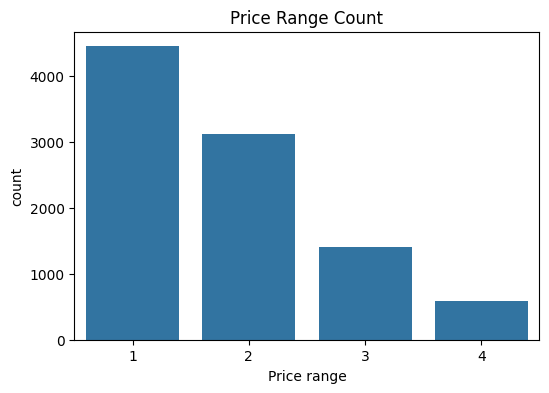

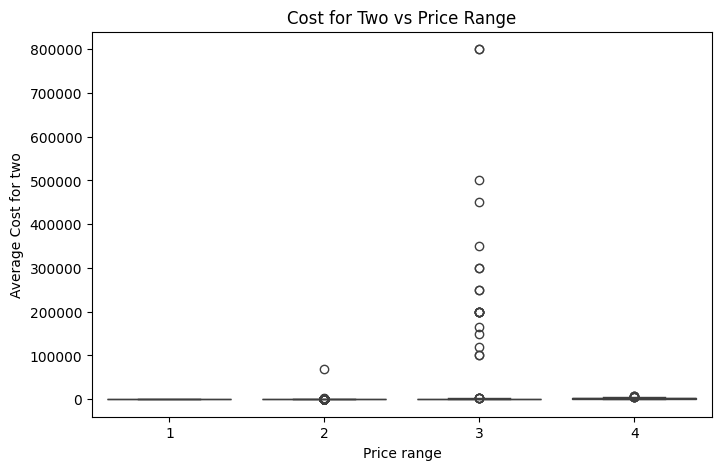

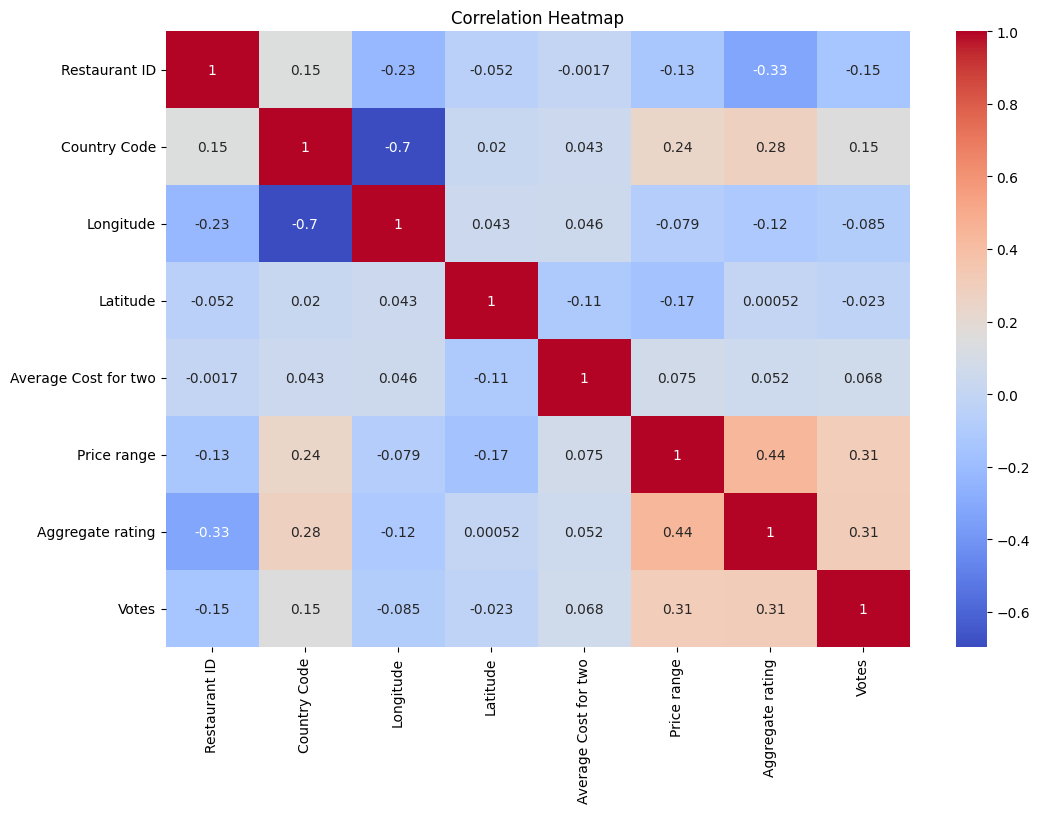

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Countplot of Price Range
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Price range')
plt.title("Price Range Count")
plt.show()

# Boxplot of Average Cost for Two by Price Range
plt.figure(figsize=(8, 5))
sns.boxplot(x='Price range', y='Average Cost for two', data=df)
plt.title("Cost for Two vs Price Range")
plt.show()

# Heatmap - Use only numeric columns
plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [14]:
# Fill missing values
df['Cuisines'] = df['Cuisines'].fillna('Not mentioned')

# ✅ Check actual columns before applying get_dummies
print("Columns before get_dummies:\n", df.columns)

# ✅ Only include columns that exist
cols_to_encode = [col for col in ['Has Table booking', 'Has Online delivery', 'Currency', 'Rating text', 'Country']
                  if col in df.columns]

# One-hot encode available columns
df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True)

# ✅ Outlier Removal (IQR method for 'Average Cost for two')
Q1 = df['Average Cost for two'].quantile(0.25)
Q3 = df['Average Cost for two'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Average Cost for two'] >= Q1 - 1.5 * IQR) & (df['Average Cost for two'] <= Q3 + 1.5 * IQR)]

# ✅ Apply PowerTransformer
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
df[['Average Cost for two']] = pt.fit_transform(df[['Average Cost for two']])


Columns before get_dummies:
 Index(['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address',
       'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines',
       'Average Cost for two', 'Is delivering now', 'Switch to order menu',
       'Price range', 'Aggregate rating', 'Rating color', 'Votes',
       'Has Table booking_Yes', 'Has Online delivery_Yes',
       'Currency_Brazilian Real(R$)', 'Currency_Dollar($)',
       'Currency_Emirati Diram(AED)', 'Currency_Indian Rupees(Rs.)',
       'Currency_Indonesian Rupiah(IDR)', 'Currency_NewZealand($)',
       'Currency_Pounds(£)', 'Currency_Qatari Rial(QR)', 'Currency_Rand(R)',
       'Currency_Sri Lankan Rupee(LKR)', 'Currency_Turkish Lira(TL)',
       'Rating text_Excellent', 'Rating text_Good', 'Rating text_Not rated',
       'Rating text_Poor', 'Rating text_Very Good', 'Country_Brazil',
       'Country_Canada', 'Country_India', 'Country_Indonesia',
       'Country_New Zealand', 'Country_Phillipines', 'Countr

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import pickle

# 🔹 Step 1: Load dataset with proper encoding
df = pd.read_csv('Zomato.csv', encoding='ISO-8859-1')  # or use 'latin1' if this fails

# 🔹 Step 2: Drop text/non-numeric columns that can't be used directly
df.drop(columns=[
    'Restaurant Name', 'Address', 'City', 'Locality', 'Locality Verbose',
    'Switch to order menu', 'Cuisines', 'Rating text', 'Currency'
], inplace=True, errors='ignore')

# 🔹 Step 3: Drop rows with missing target or features
df.dropna(inplace=True)

# 🔹 Step 4: Encode categorical features (like 'Has Table booking', etc.)
label_encodable_cols = df.select_dtypes(include=['object']).columns

for col in label_encodable_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# 🔹 Step 5: Define features (X) and target (y)
X = df.drop(['Average Cost for two'], axis=1)
y = df['Average Cost for two']

# 🔹 Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Step 7: Cross-validation
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5)
print("Cross-validated scores:", scores)
print("Average CV score:", scores.mean())

# 🔹 Step 8: Grid Search CV (optional for more advanced models)
# Here’s just an example; can be skipped if using LinearRegression
# param_grid = {'fit_intercept': [True, False], 'normalize': [True, False]}
# grid = GridSearchCV(LinearRegression(), param_grid, cv=5)
# grid.fit(X_train, y_train)
# best_model = grid.best_estimator_

# Use the simple model instead
model.fit(X_train, y_train)
best_model = model

# 🔹 Step 9: Save model using pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# 🔹 Step 10: Load and test the saved model
with open('model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Test on new data (make sure new_data matches feature shape & types)
# Example (just using part of X_test for demonstration):
sample = X_test.iloc[0:1]
prediction = loaded_model.predict(sample)
print("Predicted Average Cost for Two:", prediction[0])


Cross-validated scores: [-1.54401059e+02 -1.48248166e+01 -1.89658456e+00 -6.70792496e-01
 -7.83705443e-03]
Average CV score: -34.36021788734395
Predicted Average Cost for Two: 113.59227523886511
